In [19]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

# PhIP-Seq kinetics computations

## Reaction summary

IP reaction (1 mL)
* IgG
    * MW of IgG = 150 kDa
    * 2 µg IgG = 13.3 pmol = 8.03e12 molecules
    * **13.3 nM in the reaction**
* Phage
    * 100k particles per clone on average
    * Add ~1e10 total particles per mL reaction
    * 5k - 50k of each clone per reaction
    * Equiv to per clone concentration of 0.0083 fM to 
* Protein A/Protein G Beads
    * 40 µL total => 1.2 mg beads => capture 9.6 µg Ab according to manual
    * Should capture all Ab in reaction so will ignore in calculation
    * Kd maybe ~10 nM
    

Ab in reaction

Kd = [Ab] [L] / [AbL]

Inputs:
Desired Kd ability to resolve
Total Ab and L (e.g., [Ab] + [AbL])
requires overwhelming Protein A/G binding sites?

## Input library

In [23]:
df = pd.read_csv('/Users/laserson/lasersonlab/larman/libraries/T7-Pep_InputCountsComplete46M.csv', header=None, index_col=0)

In [24]:
counts = df.values.ravel()

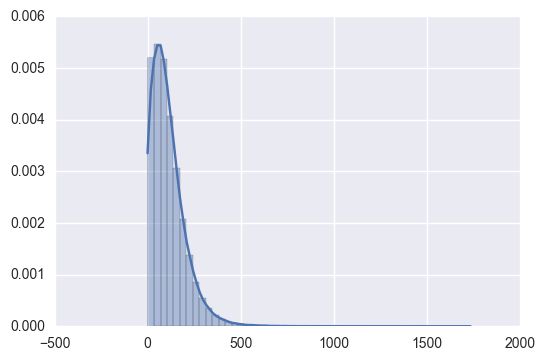

In [25]:
sns.distplot(counts)

`(min, 10%ile, 50%ile, 90%ile, max)`

In [46]:
iles = (counts.min(), sp.stats.scoreatpercentile(counts, 10), sp.stats.scoreatpercentile(counts, 50), sp.stats.scoreatpercentile(counts, 90), counts.max())
iles

(0, 18.0, 94.0, 229.0, 1736)

In [38]:
cov = sum(counts)
cov

46859607

And the same values as frequencies

In [39]:
tuple([float(val) / cov for val in iles])

(0.0,
 3.8412614087864629e-07,
 2.0059920690329308e-06,
 4.8869381256227775e-06,
 3.704683225362944e-05)

In [41]:
counts.mean(), counts.std()

(113.29390901112397, 91.683612273186029)

In [47]:
(18. / cov) * 1e10

3841.2614087864631

In [48]:
(229. / cov) * 1e10

48869.381256227774

In [52]:
(counts > 0).sum()

404255

In [53]:
counts.shape

(413611,)

In [101]:
def equil_conc(total_antibody, total_phage, Kd):
    s = total_antibody + total_phage + Kd
    bound = 0.5 * (s - np.sqrt(s * s - 4 * total_antibody * total_phage))
    equil_antibody = total_antibody - bound
    equil_phage = total_phage - bound
    return (equil_antibody, equil_phage, bound)

In [102]:
equil_conc(13e-15, 8.302889405513118e-17, 1e-9)

(1.2999998920632698e-14, 8.3027814687829376e-17, 1.079367301805132e-21)

In [103]:
np.logspace?

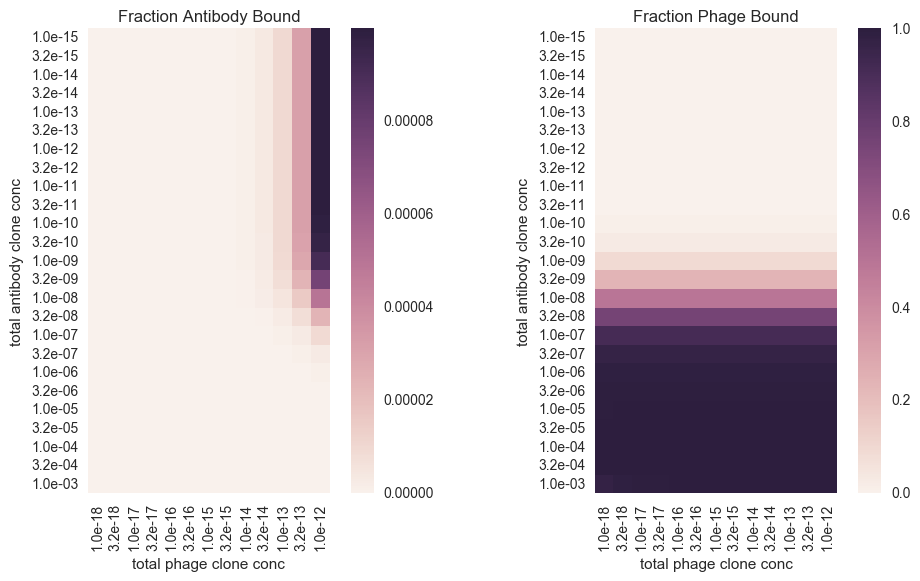

In [148]:
antibody_concentrations = np.logspace(-15, -3, num=25)
phage_concentrations = np.logspace(-18, -12, num=13)

antibody_labels = ['{:.1e}'.format(c) for c in antibody_concentrations]
phage_labels = ['{:.1e}'.format(c) for c in phage_concentrations]

Kd = 1e-8
frac_antibody_bound = np.zeros((len(antibody_concentrations), len(phage_concentrations)))
frac_phage_bound = np.zeros((len(antibody_concentrations), len(phage_concentrations)))
for (i, a) in enumerate(antibody_concentrations):
    for (j, p) in enumerate(phage_concentrations):
        bound = equil_conc(a, p, Kd)[2]
        frac_antibody_bound[i, j] = bound / a
        frac_phage_bound[i, j] = bound / p

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
sns.heatmap(frac_antibody_bound, xticklabels=phage_labels, yticklabels=antibody_labels, square=True, ax=ax)
ax.set_title('Fraction Antibody Bound')
ax.set_ylabel('total antibody clone conc')
ax.set_xlabel('total phage clone conc')
ax = fig.add_subplot(122)
sns.heatmap(frac_phage_bound, xticklabels=phage_labels, yticklabels=antibody_labels, square=True, ax=ax)
ax.set_title('Fraction Phage Bound')
ax.set_ylabel('total antibody clone conc')
ax.set_xlabel('total phage clone conc')

It's most important to ensure we get maximal phage capture, and this seems to be independent of the total phage concentration.  Let's instead explore the fraction phage bound as a function of the antibody concentration and Kd

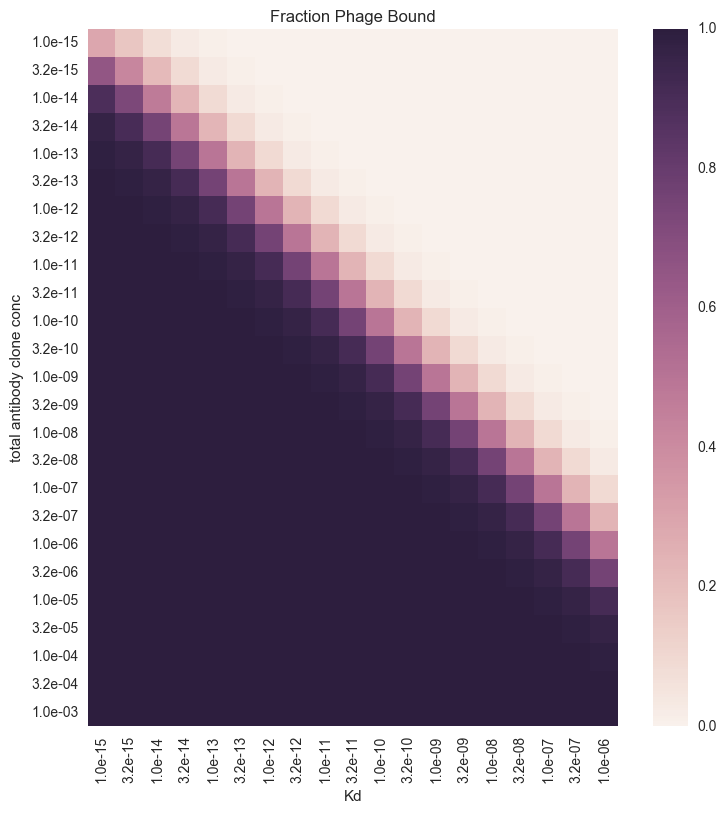

In [147]:
antibody_concentrations = np.logspace(-15, -3, num=25)
Kds = np.logspace(-15, -6, num=19)

antibody_labels = ['{:.1e}'.format(c) for c in antibody_concentrations]
Kd_labels = ['{:.1e}'.format(c) for c in Kds]

phage_concentration = 2e-15
frac_antibody_bound = np.zeros((len(antibody_concentrations), len(Kds)))
frac_phage_bound = np.zeros((len(antibody_concentrations), len(Kds)))
for (i, a) in enumerate(antibody_concentrations):
    for (j, Kd) in enumerate(Kds):
        bound = equil_conc(a, phage_concentration, Kd)[2]
        frac_antibody_bound[i, j] = bound / a
        frac_phage_bound[i, j] = bound / phage_concentration

fig = plt.figure(figsize=(9, 9))
# ax = fig.add_subplot(121)
# sns.heatmap(frac_antibody_bound, xticklabels=Kd_labels, yticklabels=antibody_labels, square=True, ax=ax)
# ax.set_title('Fraction Antibody Bound')
# ax.set_ylabel('total antibody clone conc')
# ax.set_xlabel('Kd')
ax = fig.add_subplot(111)
sns.heatmap(frac_phage_bound, xticklabels=Kd_labels, yticklabels=antibody_labels, square=True, ax=ax)
ax.set_title('Fraction Phage Bound')
ax.set_ylabel('total antibody clone conc')
ax.set_xlabel('Kd')